# **POLI170A Project**

Research question: Does increased availability of on-sale alcohol, specifically Type 41 (On-Sale Beer and Wine – Public) and Type 47 (On-Sale General – Eating), lead to higher rates of crime, such as assault or robbery, in communities in San Diego County?

# Setup

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.stats.outliers_influence import variance_inflation_factor

def standardize(X):
    return (X - X.mean()) / X.std()

In [2]:
zipcode_df = pd.read_csv("zipcode.csv", header = None)
zipcode_arr = zipcode_df[0].values

# Alcohol Dataset

Records of alcohol licenses in california, from the CA ABC daily file, with improvements to geographic identifiers, and acompilation of areal densities of on-sale and off-sale licenses in San Diego county.

* ca_abc_licenses. California Alcohol Beverage Control License records
* sd_abc_density. Areal density of on-sale and off-sale licenses in San Diego county

In [3]:
ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)

ca_licenses.head(3)

/tmp/ipykernel_3634/3604120517.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)


,License Type,File Number,Lic or App,Type Status,Type Orig Iss Date,Expir Date,Fee Codes,Dup Counts,Master Ind,Term in # of Months,...,Prem State,Prem Zip,DBA Name,Mail Addr 1,Mail Addr 2,Mail City,Mail State,Mail Zip,Prem County,Prem Census Tract #
0,77,561256,LIC,ACTIVE,01-DEC-2015,30-NOV-2024,P40,001,N,12,...,CA,91762-3644,FIREWATER BAR,,,,,,SAN BERNARDINO,0010.02
1,48,526584,LIC,ACTIVE,08-JAN-2013,31-DEC-2024,P40,001,N,12,...,CA,94578-2815,CLUB CALIENTE,PO BOX 3541,,SAN LEANDRO,CA,94578-0541,ALAMEDA,4331.03
2,77,518989,LIC,ACTIVE,21-JUN-2012,31-MAY-2024,P40,001,N,12,...,CA,93001-2826,BARRELHOUSE 101,,,,,,VENTURA,0024.00


In [4]:
ca_licenses.columns

Index(['License Type', 'File Number', 'Lic or App', 'Type Status',
       'Type Orig Iss Date', 'Expir Date', 'Fee Codes', 'Dup Counts',
       'Master Ind', 'Term in # of Months', 'Geo Code', 'District',
       'Primary Name', 'Prem Addr 1', ' Prem Addr 2', 'Prem City',
       ' Prem State', 'Prem Zip', 'DBA Name', 'Mail Addr 1', 'Mail Addr 2',
       'Mail City', 'Mail State', 'Mail Zip', 'Prem County',
       'Prem Census Tract #'],
      dtype='object')

## Data Cleaning

1. dealing with license issue date, expire date

In [5]:
# drop rows with NaN values in 'Type Orig Iss Date' and 'Expir Date'
ca_licenses['Type Orig Iss Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses['Expir Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses.dropna(subset=['Type Orig Iss Date', 'Expir Date'], inplace=True)

# convert to datatime
ca_licenses['Type Orig Iss Date'] = pd.to_datetime(ca_licenses['Type Orig Iss Date'], format='%d-%b-%Y')
ca_licenses['Expir Date'] = pd.to_datetime(ca_licenses['Expir Date'], format='%d-%b-%Y')

2. transform all zipcode into 5-digits format

In [6]:
ca_licenses['Prem Zip'] = ca_licenses['Prem Zip'].str.slice(0, 5)

3. filter the dataframe based on the following conditions:
  * Is an active License (Lic) not an Application (App) that is still being processed
  * issue date before 2016-01-01
  * expire date after 2020-07-31
  * license is active
  * license type is 41, 47, or 48
  (41; On-Sale Beer and Wine – Public, 47: On-Sale General – Eating, 48: On-Sale General — Public ( Bars and Nightclubs ))
  * license is used within San Diego

In [7]:
df_alcohol = ca_licenses[
    (ca_licenses['Lic or App'] == 'LIC') &
    (ca_licenses['Type Orig Iss Date'] < '2016-01-01') &
    (ca_licenses['Expir Date'] > '2020-07-31') &
    (ca_licenses['Type Status'] == 'ACTIVE') &
    ((ca_licenses['License Type'] == 47) | (ca_licenses['License Type'] == 41) | (ca_licenses['License Type'] == 48)) &
    (ca_licenses['Prem County'] == "SAN DIEGO")
].reset_index(drop = True)

4. select important features <br>

In [8]:
sub_alcohol = df_alcohol[['Type Orig Iss Date', 'Expir Date', 'DBA Name', 'Prem Addr 1', 'Prem City', 'Prem Zip']]
sub_alcohol.head(5)

,Type Orig Iss Date,Expir Date,DBA Name,Prem Addr 1,Prem City,Prem Zip
0,2013-01-16,2024-12-31,LAUBERGE DEL MAR,1540 CAMINO DEL MAR,DEL MAR,92014
1,1994-09-26,2024-12-31,CASBAH THE,2501 KETTNER BLVD,SAN DIEGO,92101
2,1993-12-31,2024-11-30,CATAMARAN RESORT HOTEL,3999 MISSION BLVD,SAN DIEGO,92109
3,2012-01-12,2024-12-31,MANCHESTER GRAND HYATT SAN DIEGO,ONE MARKET PLACE,SAN DIEGO,92101
4,2012-01-19,2024-12-31,BARLEY MASH,600 5TH AVE,SAN DIEGO,92101


In [9]:
nlicense = (sub_alcohol.groupby('Prem Zip')
            ['DBA Name']
            .count()
            .to_frame(name='license_count')
            .reset_index())
nlicense.columns = ['zipcode', 'license_count']
nlicense['zipcode'] = nlicense['zipcode'].astype(int)
nlicense

,zipcode,license_count
0,91901,10
1,91902,6
2,91906,1
3,91910,40
4,91911,17
...,...,...
86,92131,11
87,92139,2
88,92154,9
89,92173,4


# Crime Dataset

This dataset describes crime incidents from 2016 to 2020, with demographic information for the victims. The file has one row per incident. The dataset is derived from data acquired for a PRA request and is processed to standardize geographic identifiers and racial categories.

In [10]:
crime_df =  pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/sdcrime_16_20_uniquecase.csv')
crime_df.head(3)

,activitynumber,activitydate,year,agency,violationsection,violationtype,chargedescription,chargelevel,codeucr,crimecategory,personrole,race,age,sex,zipcode,censusblock,censustract,city,city.1
0,'01600014',2016-01-01 00:00:00,2016,NATIONAL CITY,10851,VC,TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT,FELONY,7A0,Vehicle Theft,VICTIM,OTHER,NaN,FEMALE,91950.0,'02000','022000',NATIONAL CITY,NATIONAL CITY
1,'16000042',2016-01-01 00:00:00,2016,SAN DIEGO,459,PC,BURGLARY/UNSPECIFIED,FELONY,5A6,Non Res Burglary,NaN,NaN,NaN,NaN,92109.0,'20000','007907',SAN DIEGO,SAN DIEGO
2,'16005661',2016-01-01 00:00:00,2016,SAN DIEGO,488,PC,PETTY THEFT,MISDEMEANOR,6DG,Larceny < $400,VICTIM/WITNESS,HISPANIC,74.0,MALE,92115.0,'20230','002902',SAN DIEGO,SAN DIEGO


In [11]:
crime_df.columns

Index(['activitynumber', 'activitydate', 'year', 'agency', 'violationsection',
       'violationtype', 'chargedescription', 'chargelevel', 'codeucr',
       'crimecategory', 'personrole', 'race', 'age', 'sex', 'zipcode',
       'censusblock', 'censustract', 'city', 'city.1'],
      dtype='object')

## Data Cleaning

1. clean columns: city, zipcode

In [12]:
# keep one of them is enough
(crime_df['city'] == crime_df['city.1']).all()

True

In [13]:
# drop all rows that containing nan in zipcode
crime_df = crime_df.dropna(subset=['zipcode'])

# convert zipcode type into int64
crime_df.loc[:, 'zipcode'] = crime_df['zipcode'].astype(int)

# filter df only include sd cities
crime_df = crime_df[crime_df['zipcode'].isin(zipcode_arr)]

# convert datatype of zipcode
crime_df['zipcode'] = crime_df['zipcode'].astype(int)

In [14]:
crime_df['city'] = crime_df['city'].str.strip()
crime_df['city'] = crime_df['city'].str.replace(r'\bUNINC\b|\bUNIN\b', '', regex=True)
crime_df['city'] = crime_df['city'].replace({'SAM DIEGO': 'SAN DIEGO', 'SAN SIEGO': 'SAN DIEGO',
                                             '5310 LA MESA': 'LA MESA', 'LAMESA': 'LA MESA',
                                             '92013': 'CARLSBAD', 'SPING VALLEY': 'SPRING VALLEY',
                                             'SAN YSABEL': 'SANTA YSABEL'})

crime_df = crime_df[(crime_df['city'] != 'CN') & (crime_df['city'] != 'SD COUNTY')]

In [15]:
sub_crime = crime_df[['activitynumber', 'activitydate', 'violationtype', 'crimecategory', 'zipcode', 'city']]

In [16]:
sub_crime

,activitynumber,activitydate,violationtype,crimecategory,zipcode,city
0,'01600014',2016-01-01 00:00:00,VC,Vehicle Theft,91950,NATIONAL CITY
1,'16000042',2016-01-01 00:00:00,PC,Non Res Burglary,92109,SAN DIEGO
2,'16005661',2016-01-01 00:00:00,PC,Larceny < $400,92115,SAN DIEGO
3,'16008822',2016-01-01 00:00:00,PC,Larceny >= $400,92109,SAN DIEGO
5,'16016207',2016-01-01 00:00:00,PC,Larceny >= $400,92126,SAN DIEGO
...,...,...,...,...,...,...
312084,'20132063',2020-07-31 23:00:00,VC,Vehicle Theft,91945,LEMON GROVE
312085,'20303289',2020-07-31 23:00:00,VC,Vehicle Theft,92114,SAN DIEGO
312086,'20303297',2020-07-31 23:00:00,VC,Vehicle Theft,92108,SAN DIEGO
312087,'20132066',2020-07-31 23:23:00,PC,Aggravated Assault,92028,FALLBROOK


2. Aggregate based on `zipcode`

In [17]:
ncrime = (sub_crime.groupby('zipcode')
          ['activitynumber']
          .count()
          .to_frame()
          .reset_index()
         .rename(columns={'activitynumber': 'crime_count'}))
ncrime

,zipcode,crime_count
0,91901,1283
1,91902,1038
2,91905,163
3,91906,278
4,91909,4
...,...,...
127,92173,4166
128,92182,27
129,92195,2
130,92196,1


3. Merge nlicense data with ncrime data

In [18]:
merged_df = pd.merge(ncrime, nlicense, on='zipcode', how='inner')
merged_df 

,zipcode,crime_count,license_count
0,91901,1283,10
1,91902,1038,6
2,91906,278,1
3,91910,9366,40
4,91911,8699,17
...,...,...,...
83,92131,1401,11
84,92139,2377,2
85,92154,7011,9
86,92173,4166,4


# Load helper datasets: density, poverty, pop

`density`: population density; the estimated population per square kilometer

https://simplemaps.com/data/us-zips

In [19]:
density = pd.read_csv("popden.csv")

density = density[['zip', 'density']]
density.columns = ['zipcode', 'density']

density['zipcode'] = density['zipcode'].astype(int)
density['density'] = density['density'].astype(float)

density

,zipcode,density
0,601,100.9
1,602,479.2
2,603,551.7
3,606,48.7
4,610,265.7
...,...,...
33782,99923,0.6
33783,99925,6.6
33784,99926,4.3
33785,99927,1.2


`poverty`: number of people identified as poverty status within each zipcode
    
Source: ID: ACSST5Y2022.S1701
Title: Poverty Status in the Past 12 Months

In [20]:
poverty = pd.read_csv("poverty.csv")

poverty = poverty[['NAME', 'S1701_C02_001E']].iloc[1:]
poverty.columns = ['zipcode', 'poverty']

poverty['zipcode'] = poverty['zipcode'].apply(lambda x: int(x.split()[-1]))
poverty['poverty'] = poverty['poverty'].astype(int)
poverty

,zipcode,poverty
1,89010,5
2,89019,186
3,89060,2183
4,89061,486
5,89439,93
...,...,...
1804,96148,15
1805,96150,3263
1806,96155,0
1807,96161,1602


`population`: total number of people within each zipcode

Source: 
ID: ACSDP5Y2022.DP05
Title: ACS Demographic and Housing Estimates

In [21]:
pop = pd.read_csv("pop_zc.csv")

pop = pop[['NAME', 'DP05_0001E']].iloc[1:]
pop.columns = ['zipcode', 'population']

pop['zipcode'] = pop['zipcode'].apply(lambda x: int(x.split()[-1]))
pop['population'] = pop['population'].astype(int)

pop

/tmp/ipykernel_3634/1723714238.py:1: DtypeWarning: Columns (2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,58,59,60,61,62,63,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,232,240,248,312,326,360) have mixed types. Specify dtype option on import or set low_memory=False.
  pop = pd.read_csv("pop_zc.csv")


,zipcode,population
1,601,16834
2,602,37642
3,603,49075
4,606,5590
5,610,25542
...,...,...
33770,99923,25
33771,99925,920
33772,99926,1465
33773,99927,14


Merge all columns back to merged_df

In [22]:
# recall merged_df
merged_df

,zipcode,crime_count,license_count
0,91901,1283,10
1,91902,1038,6
2,91906,278,1
3,91910,9366,40
4,91911,8699,17
...,...,...,...
83,92131,1401,11
84,92139,2377,2
85,92154,7011,9
86,92173,4166,4


In [23]:
merged_df = pd.merge(merged_df, pop, on='zipcode', how='inner')
merged_df = pd.merge(merged_df, poverty, on='zipcode', how='inner')
merged_df = pd.merge(merged_df, density, on='zipcode', how='inner')
merged_df

,zipcode,crime_count,license_count,population,poverty,density
0,91901,1283,10,18669,1622,92.6
1,91902,1038,6,17121,888,589.3
2,91906,278,1,4281,1103,15.7
3,91910,9366,40,76313,8299,2340.9
4,91911,8699,17,87799,9752,2663.4
...,...,...,...,...,...,...
83,92131,1401,11,35227,1155,352.0
84,92139,2377,2,34930,2894,3769.6
85,92154,7011,9,83758,8119,630.4
86,92173,4166,4,28609,4656,3838.9


In [24]:
merged_df.dropna(inplace=True)
merged_df = merged_df[merged_df['population'] != 0]

merged_df['alcohol_density'] = merged_df['license_count'] / merged_df['population']
merged_df['crime_density'] = merged_df['crime_count'] / merged_df['population']
merged_df['poverty_rate'] = merged_df['poverty'] / merged_df['population']

# Filter out rows where 'alcohol_density' or 'crime_density' is NaN or 0
merged_df = merged_df[(merged_df['alcohol_density'].notna()) & (merged_df['alcohol_density'] != 0)]
merged_df = merged_df[(merged_df['crime_density'].notna()) & (merged_df['crime_density'] != 0)]

# Apply log transformation
merged_df['log_alcohol_density'] = merged_df['alcohol_density'].apply(lambda x: np.log(x) if x > 0 else np.nan)
merged_df['log_crime_density'] = merged_df['crime_density'].apply(lambda x: np.log(x) if x > 0 else np.nan)
merged_df['cbrt_pop_density'] = merged_df['density'].apply(lambda x: np.cbrt(x) if x > 0 else np.nan)

/tmp/ipykernel_3634/1032684787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['alcohol_density'] = merged_df['license_count'] / merged_df['population']
/tmp/ipykernel_3634/1032684787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['crime_density'] = merged_df['crime_count'] / merged_df['population']
/tmp/ipykernel_3634/1032684787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Get finalized merged_df

In [25]:
merged_df

,zipcode,crime_count,license_count,population,poverty,density,alcohol_density,crime_density,poverty_rate,log_alcohol_density,log_crime_density,cbrt_pop_density
0,91901,1283,10,18669,1622,92.6,0.000536,0.068724,0.086882,-7.532035,-2.677663,4.524150
1,91902,1038,6,17121,888,589.3,0.000350,0.060627,0.051866,-7.956302,-2.803010,8.383888
2,91906,278,1,4281,1103,15.7,0.000234,0.064938,0.257650,-8.361942,-2.734321,2.503994
3,91910,9366,40,76313,8299,2340.9,0.000524,0.122731,0.108749,-7.553719,-2.097757,13.277846
4,91911,8699,17,87799,9752,2663.4,0.000194,0.099079,0.111072,-8.549592,-2.311842,13.861561
...,...,...,...,...,...,...,...,...,...,...,...,...
82,92130,2297,14,57363,2570,1193.0,0.000244,0.040043,0.044802,-8.318097,-3.217796,10.605883
83,92131,1401,11,35227,1155,352.0,0.000312,0.039771,0.032787,-8.071673,-3.224627,7.060697
84,92139,2377,2,34930,2894,3769.6,0.000057,0.068050,0.082851,-9.767954,-2.687507,15.563183
85,92154,7011,9,83758,8119,630.4,0.000107,0.083705,0.096934,-9.138462,-2.480451,8.574433


In [26]:
merged_df.to_csv('merged_df.csv', index=False)

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 86
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zipcode              87 non-null     int64  
 1   crime_count          87 non-null     int64  
 2   license_count        87 non-null     int64  
 3   population           87 non-null     int64  
 4   poverty              87 non-null     int64  
 5   density              87 non-null     float64
 6   alcohol_density      87 non-null     float64
 7   crime_density        87 non-null     float64
 8   poverty_rate         87 non-null     float64
 9   log_alcohol_density  87 non-null     float64
 10  log_crime_density    87 non-null     float64
 11  cbrt_pop_density     87 non-null     float64
dtypes: float64(7), int64(5)
memory usage: 8.8 KB


## EDA

**Univariate Analysis**

In the univariate analysis, we would analyze the distribution of alcohol_density and the distribution of crime_density separately.

Firstly, let's check the descriptive statistics of two variables.

In [28]:
merged_df.describe()

,zipcode,crime_count,license_count,population,poverty,density,alcohol_density,crime_density,poverty_rate,log_alcohol_density,log_crime_density,cbrt_pop_density
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,92048.666667,3415.574713,18.448276,36486.816092,3800.804598,1536.390805,0.000698,0.098203,0.102575,-7.790633,-2.510859,10.172477
std,73.649653,3253.618131,24.219807,21842.011742,3281.178723,1283.419919,0.000771,0.074933,0.057432,1.065250,0.583219,4.158375
min,91901.000000,43.000000,1.000000,506.000000,0.000000,1.400000,0.000015,0.023634,0.000000,-11.104762,-3.745083,1.118689
25%,92008.500000,1387.000000,5.000000,19327.500000,1437.000000,403.250000,0.000215,0.052590,0.063176,-8.444893,-2.945238,7.386355
50%,92064.000000,2716.000000,12.000000,37050.000000,2898.000000,1228.100000,0.000365,0.077280,0.092649,-7.915376,-2.560317,10.708893
75%,92110.500000,4422.500000,22.000000,51121.000000,5026.500000,2377.250000,0.000914,0.119239,0.120764,-7.000290,-2.126626,13.346216
max,92173.000000,22374.000000,187.000000,87799.000000,16721.000000,4876.100000,0.004063,0.486127,0.371328,-5.505831,-0.721285,16.957332


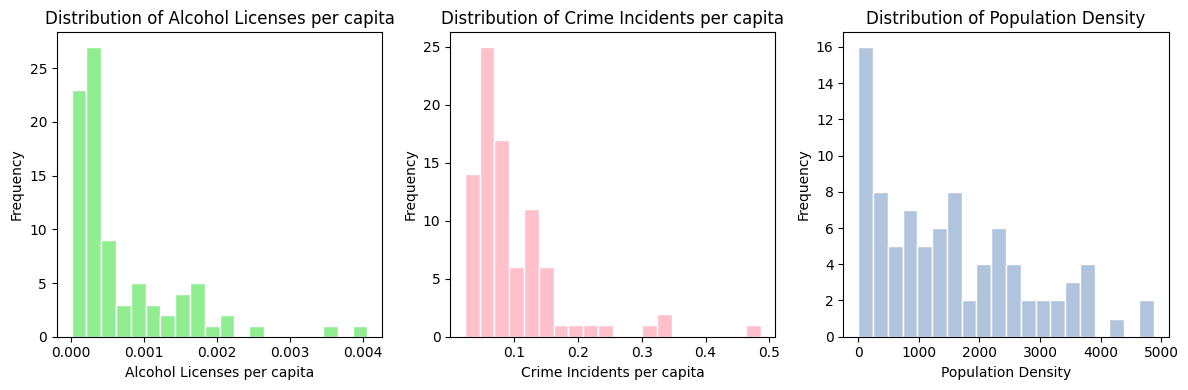

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

merged_df['alcohol_density'].plot(kind='hist', bins=20, ax=axs[0], color='lightgreen', edgecolor='white')
axs[0].set_title('Distribution of Alcohol Licenses per capita')
axs[0].set_xlabel('Alcohol Licenses per capita')

merged_df['crime_density'].plot(kind='hist', bins=20, ax=axs[1], color='pink', edgecolor='white')
axs[1].set_title('Distribution of Crime Incidents per capita')
axs[1].set_xlabel('Crime Incidents per capita')

merged_df['density'].plot(kind='hist', bins=20, ax=axs[2], color='lightsteelblue', edgecolor='white')
axs[2].set_title('Distribution of Population Density')
axs[2].set_xlabel('Population Density')

plt.tight_layout()


plt.savefig('histograms_distribution.png', dpi=300)
plt.show()

After transformed, the distribution is relatively normal distributed.

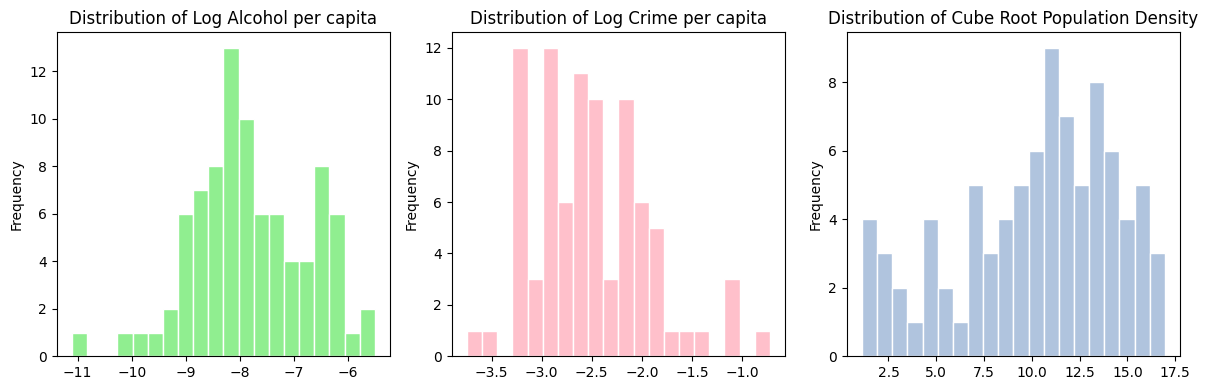

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

merged_df['log_alcohol_density'].plot(kind='hist', bins=20, ax=axs[0], color='lightgreen', edgecolor='white')
axs[0].set_title('Distribution of Log Alcohol per capita')

merged_df['log_crime_density'].plot(kind='hist', bins=20, ax=axs[1], color='pink', edgecolor='white')
axs[1].set_title('Distribution of Log Crime per capita')

merged_df['cbrt_pop_density'].plot(kind='hist', bins=20, ax=axs[2], color='lightsteelblue', edgecolor='white')
axs[2].set_title('Distribution of Cube Root Population Density')

plt.tight_layout()
plt.show()

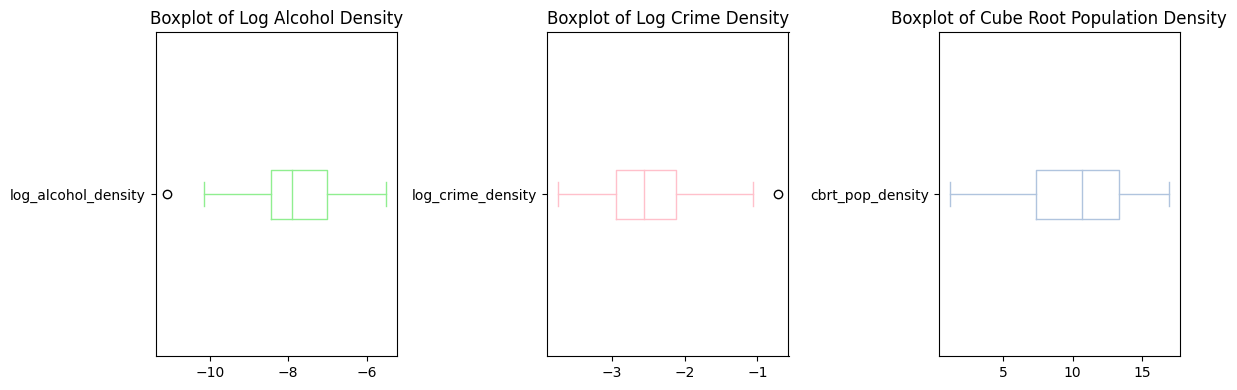

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

merged_df['log_alcohol_density'].plot(kind='box', vert = False, ax=axs[0], color='lightgreen')
axs[0].set_title('Boxplot of Log Alcohol Density')

merged_df['log_crime_density'].plot(kind='box', vert = False, ax=axs[1], color='pink')
axs[1].set_title('Boxplot of Log Crime Density')

merged_df['cbrt_pop_density'].plot(kind='box', vert = False, ax=axs[2], color='lightsteelblue')
axs[2].set_title('Boxplot of Cube Root Population Density')

plt.tight_layout()
plt.show()

**Bivariate Analysis**

explore relationship between alcohol_density and crime_density

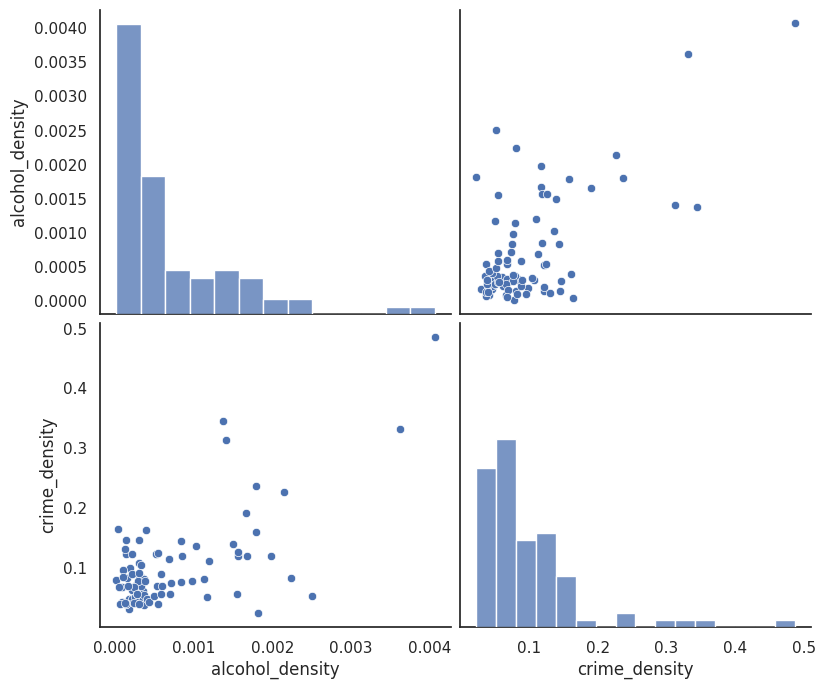

In [36]:
sns.set(style="white")
sns.pairplot(merged_df[['alcohol_density', 'crime_density']], kind = 'scatter', height=3.5, aspect=1.2)

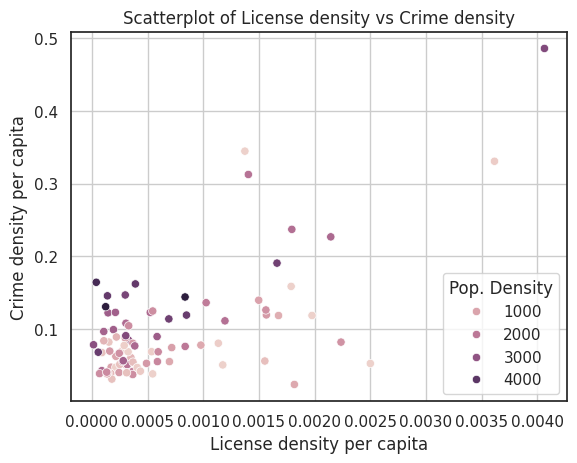

In [37]:
sns.scatterplot(data=merged_df, x='alcohol_density', y='crime_density', hue='density')

plt.xlabel('License density per capita')
plt.ylabel('Crime density per capita')
plt.title('Scatterplot of License density vs Crime density')
plt.grid(True)

legend = plt.legend(loc='lower right')
legend.set_title('Pop. Density')

## Inferential Analysis: OLS

Even though the relationship is not apparent in scatterplot visualization, it is necessary to assess the results of a linear regression to determine whether there is a statistically significant relationship between log alcohol density and crime desntiy per capita.

### model

In [38]:
full_model = smf.ols('crime_density ~ alcohol_density + density', data=merged_df).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:          crime_density   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     54.36
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           7.14e-16
Time:                        21:38:57   Log-Likelihood:                 138.61
No. Observations:                  87   AIC:                            -271.2
Df Residuals:                      84   BIC:                            -263.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0186      0.010     

Explanation:


1. 0.0186 represents the baseline level of `crime_density` when both alcohol_density and density are zero. It suggests that if there were no alcohol outlets and population density were negligible, the crime_density would still be around 0.0186 per capita.

2. For each unit increase in `alcohol_density`, crime_density is expected to increase by 66.8931, holding population density constant. This suggests a strong positive relationship between the presence of alcohol outlets (alcohol_density) and crime density. In practical terms, areas with more alcohol outlets tend to experience higher crime densities.

3. For each one-unit increase in `density`, crime_density increases by 0.00002142 units. While the coefficient is small, it shows that population density has a positive relationship with crime density. As more people are packed into a given area, crime density slightly increases, even if the effect is relatively modest compared to alcohol_density.

4. R-squared: 0.564: This indicates that approximately 56.4% of the variability in crime_density can be explained by the model.

### Diagnostics: check OLS assumptions

1. Linearity

Since residual plot show random scattering around zero for different values of the independent variable, thus the linearity assumption holds.

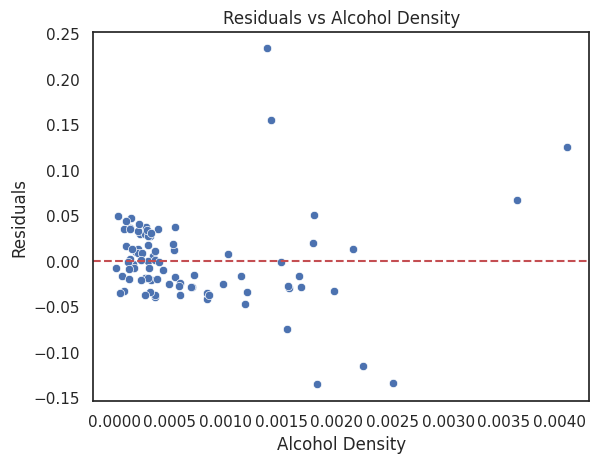

In [39]:
merged_df['residuals'] = full_model.resid

sns.scatterplot(data=merged_df, x='alcohol_density', y='residuals')
plt.title('Residuals vs Alcohol Density')
plt.xlabel('Alcohol Density')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--') 
plt.show()

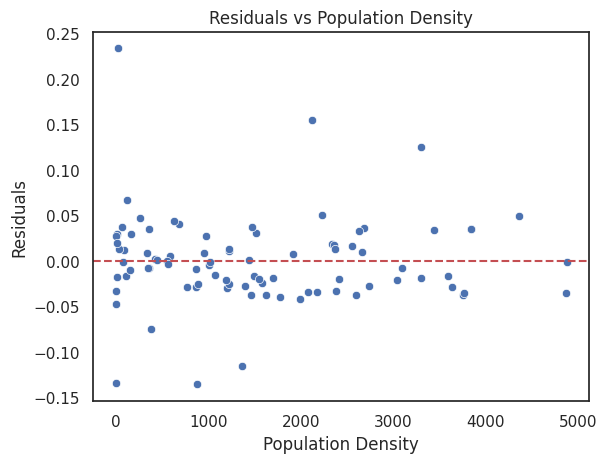

In [40]:
sns.scatterplot(data=merged_df, x='density', y='residuals')
plt.title('Residuals vs Population Density')
plt.xlabel('Population Density')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--') 
plt.show()

2. **Normality** <br>

This Q-Q plot with points closely following the diagonal line indicates that the data is likely normally distributed.

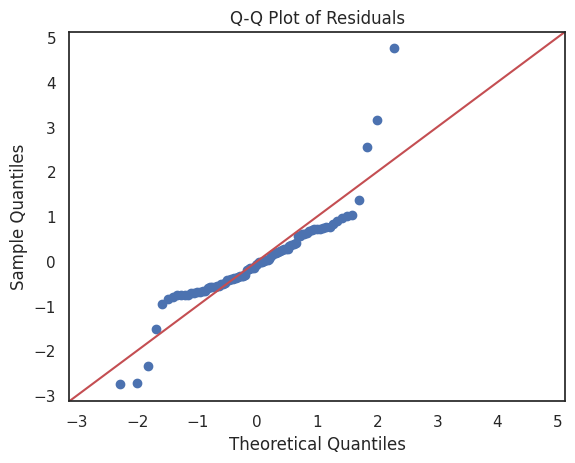

In [41]:
residuals = standardize(full_model.resid)
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

3. **Heteroscedasticity** <br>

Heteroscedasticity occurs when the variance of the errors in a regression model is not constant across observations. The identical assumption on the $\epsilon_i$ requires that the errors have constant variance. This can be checked by plotting the residuals against the predicted values of $y$. The residual plot does not show strong pattern, indicating homoscedasticity (constant variance of errors), and therefore the assumption holds.

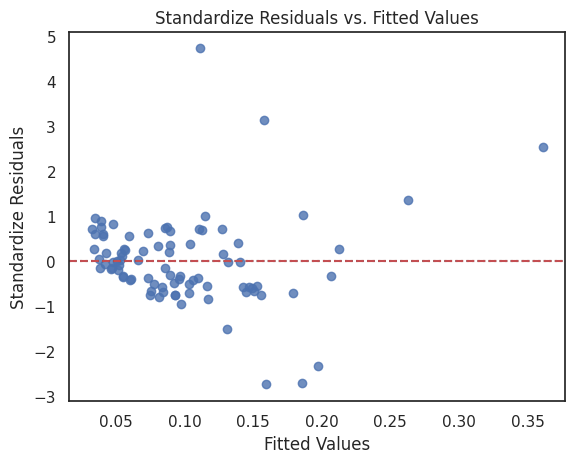

In [42]:
fitted_values = full_model.fittedvalues

sns.residplot(x=fitted_values, y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Standardize Residuals')
plt.title('Standardize Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

4. **Independence** <br>
The assumption of independence, which means that the residuals (errors) are independent of each other, appears to be violated. The Durbin-Watson statistic of 1.909 is close to 2, suggesting there is **no strong autocorrelation** in the residuals.

The independence assumption on the $\epsilon_i$ requires that the errors are all independent. This can be checked by plotting the ACF functions for the residuals. We can see only one significant spike outside the confidence bands, this indicates **no strong autocorrelation** in the residuals.

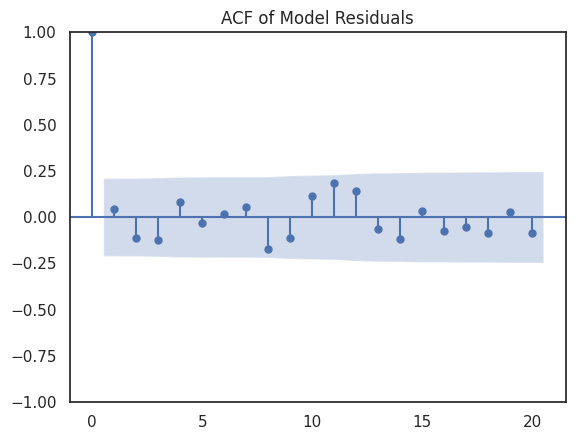

In [43]:
plot_acf(residuals)
plt.title('ACF of Model Residuals')
plt.show()

5. **Multicollinearity**<br>
The Variance Inflation Factor (VIF) is a measure used to detect multicollinearity in regression models. A VIF value greater than 10 is often considered indicative of high multicollinearity, which can affect the stability and interpretability of the regression coefficients.

All variables have VIF values below 5. This indicates that they do not have severe multicollinearity issues.

In [44]:
X = merged_df[['alcohol_density', 'density']]

# add a constant term for the intercept
X = sm.add_constant(X)

# calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

           feature       VIF
0            const  3.491031
1  alcohol_density  1.007839
2          density  1.007839


### Hypothesis Test

We apply a permutation test to further explore the statistical significant relationship between alcohol_density per capita and crime_density per capita among different areas in San Diego.

For this analysis, we will categorize areas based on alcohol_density. We define an area as high_alcohol-densed if its alcohol_density greater than the median alchol_density value of all areas. We will utilize a permutation test to assess the differences in average crime_density between high-densed regions and low-densed regions.

**Null Hypothesis (H0)**:
Every region has an identical crime density, regardless of its alcohol density level.

**Alternative Hypothesis (H1)**:
Areas characterized by high alcohol density are anticipated to have a higher crime density. This expectation is grounded in the hypothesis that increased availability and consumption of alcohol can lead to higher incidences of behaviors and situations that contribute to crime, such as impaired judgment, increased aggression, and social disorder. Additionally, areas with a high density of alcohol-serving establishments may attract larger crowds and have higher levels of social interaction, which can increase the likelihood of criminal activities.

Test statistic: Difference in average crime density.

Significant level: 0.05

In [45]:
df_hp = merged_df.copy()
median_al = df_hp['alcohol_density'].median()
df_hp['high_densed'] = df_hp['alcohol_density'] > median_al

observed_diff = df_hp[df_hp['high_densed']]['crime_density'].mean() - df_hp[~df_hp['high_densed']]['crime_density'].mean()

perm_diffs = []
for _ in range(1000):
    df_hp['shuffled_high_densed'] = np.random.permutation(df_hp['high_densed'])
    
    mean_high = df_hp[df_hp['shuffled_high_densed']]['crime_density'].mean()
    mean_low = df_hp[~df_hp['shuffled_high_densed']]['crime_density'].mean()
    
    perm_diffs.append(mean_high - mean_low)

perm_diffs = np.array(perm_diffs)
p_value = np.mean(perm_diffs >= observed_diff)

alpha = 0.05
if p_value < alpha:
    decision = "reject the null hypothesis"
else:
    decision = "fail to reject the null hypothesis"

print(f'P-value: {p_value}')
print(f'Decision: We {decision}.')

P-value: 0.0
Decision: We reject the null hypothesis.


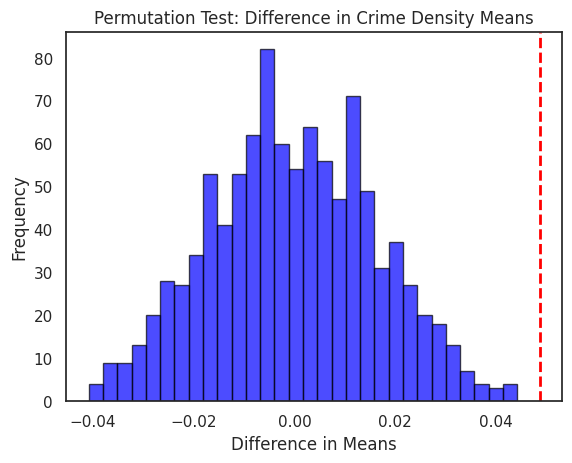

In [46]:
plt.hist(perm_diffs, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Permutation Test: Difference in Crime Density Means')
plt.show()

## GIS

In [47]:
shape_df = pd.read_csv("shapefile.csv")

In [48]:
map_df = shape_df.merge(merged_df, left_on='ZIP', right_on='zipcode').drop(columns=['zipcode'])

In [49]:
from shapely import wkt
map_df['geometry'] = map_df['the_geom'].apply(wkt.loads)

In [50]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(map_df, geometry='geometry')

In [52]:
gdf.head()

,SHAPE_STAr,ZIP,the_geom,COMMUNITY,SHAPE_STLe,crime_count,license_count,population,poverty,density,alcohol_density,crime_density,poverty_rate,log_alcohol_density,log_crime_density,cbrt_pop_density,residuals,geometry
0,4.149940e+09,91901,MULTIPOLYGON (((-116.74539162745315 32.9606312...,Alpine,326045.262676,1283,10,18669,1622,92.6,0.000536,0.068724,0.086882,-7.532035,-2.677663,4.524150,0.012305,"MULTIPOLYGON (((-116.74539 32.96063, -116.7408..."
1,2.739094e+08,91902,MULTIPOLYGON (((-116.97171627422289 32.7083793...,Bonita,113257.374615,1038,6,17121,888,589.3,0.000350,0.060627,0.051866,-7.956302,-2.803010,8.383888,0.005960,"MULTIPOLYGON (((-116.97172 32.70838, -116.9712..."
2,3.066759e+09,91906,MULTIPOLYGON (((-116.3567713215266 32.70460454...,Campo,287410.325075,278,1,4281,1103,15.7,0.000234,0.064938,0.257650,-8.361942,-2.734321,2.503994,0.030372,"MULTIPOLYGON (((-116.35677 32.70460, -116.3572..."
3,4.034374e+08,91910,MULTIPOLYGON (((-117.06354233507422 32.6501109...,Chula Vista,112587.791814,9366,40,76313,8299,2340.9,0.000524,0.122731,0.108749,-7.553719,-2.097757,13.277846,0.018933,"MULTIPOLYGON (((-117.06354 32.65011, -117.0634..."
4,3.290440e+08,91911,MULTIPOLYGON (((-117.04640746261937 32.6284554...,Chula Vista,93108.695144,8699,17,87799,9752,2663.4,0.000194,0.099079,0.111072,-8.549592,-2.311842,13.861561,0.010485,"MULTIPOLYGON (((-117.04641 32.62846, -117.0463..."


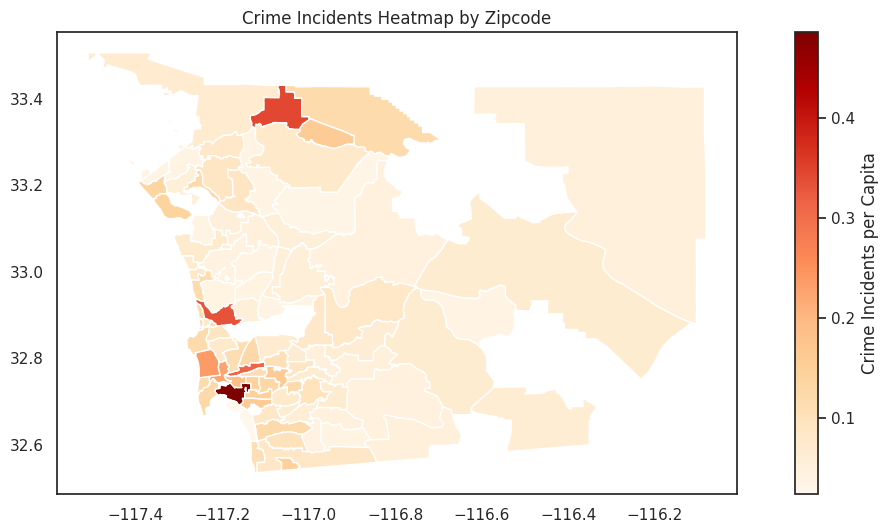

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
gdf.plot(column='crime_density', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Crime Incidents per Capita"})
plt.title('Crime Incidents Heatmap by Zipcode')


plt.savefig('crime_heatmap.png', dpi=300)
plt.show()

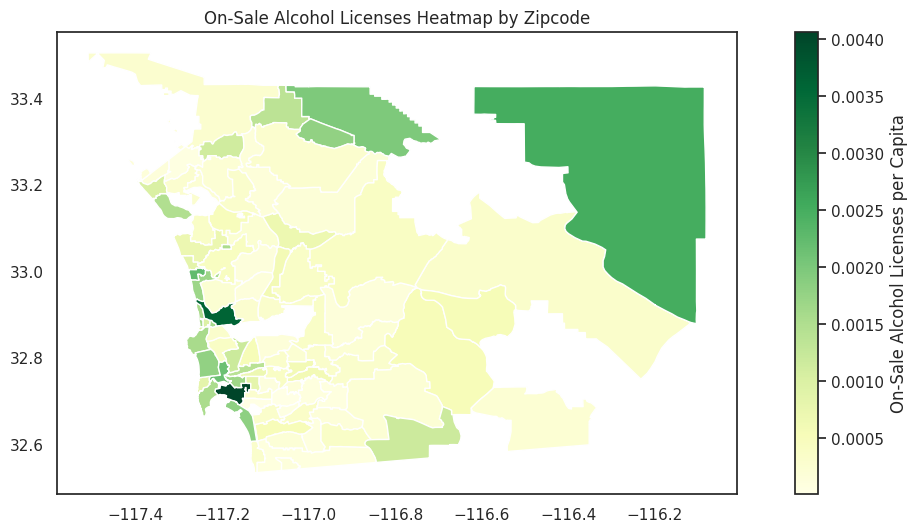

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
gdf.plot(column='alcohol_density', 
         ax=ax, 
         legend=True, 
         cmap='YlGn', 
         legend_kwds={'label': "On-Sale Alcohol Licenses per Capita"})
plt.title('On-Sale Alcohol Licenses Heatmap by Zipcode')

plt.savefig('alcohol_heatmap.png', dpi=300)
plt.show()

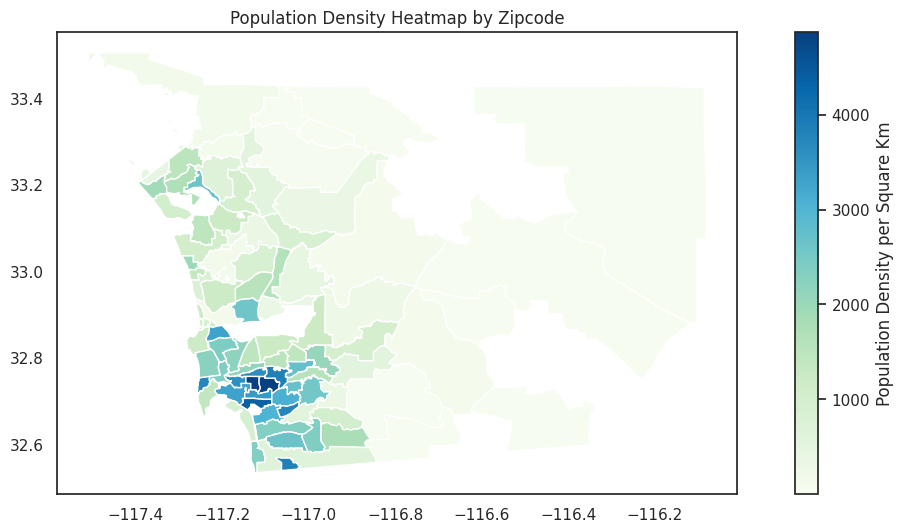

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
gdf.plot(column='density', 
         ax=ax, 
         legend=True, 
         cmap='GnBu', 
         legend_kwds={'label': "Population Density per Square Km"})
plt.title('Population Density Heatmap by Zipcode')
plt.savefig('population_heatmap.png', dpi=300)
plt.show()